# Decision Trees for AD severity classification

In [52]:
# Make sure to install these libraries (one by one)pip install pandas
pip install scikit-learn
pip install xgboost
pip install matplotlib
pip install mahotas

SyntaxError: invalid syntax (3427888156.py, line 2)

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import mahotas as mh  # Import the mahotas library for texture feature extraction

## Preprocessing (from preprocessing.ipynb)

### Data Loading

In [ ]:
# Directory to MRI Images
data_dir = 'data/AugmentedAlzheimerDataset'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

if not os.path.exists('dataset.csv'):
    # Your code to generate dataset.csv goes here
    data = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            data.append([image_path, label])

    df = pd.DataFrame(data, columns=['path', 'label'])
    df.to_csv('dataset.csv', index=False)
    print("CSV file 'dataset.csv' has been created.")
else:
    print("The CSV file 'dataset.csv' already exists.")


The CSV file 'dataset.csv' already exists.


### Data Preprocessing

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define a transformation for the CNN model (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to match the input size of the pre-trained model
    transforms.ToTensor(),  # Convert image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])

# Load the entire dataset
dataset = CustomDataset(csv_file='dataset.csv', transform=transform)


In [ ]:
# Split the dataset into train, validation, and test sets
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset,  test_dataset = random_split(dataset, [train_size, test_size])

print(f'Training Samples: {len(train_dataset)}')
print(f'Test Samples: {len(test_dataset)}')

Training Samples: 28886
Test Samples: 5098


In [ ]:
# Create DataLoader objects for training, validation, and test datasets
# batch_size = 64  # Adjust the batch size as needed
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Create an empty list to accumulate the data
data_accumulator = []

# Loop through the train_dataset to extract data
for idx in range(len(train_dataset)):
    image, label = train_dataset[idx]
    data_accumulator.append([image, label])

# Create a DataFrame from the accumulated data
train_df = pd.DataFrame(data_accumulator, columns=['image', 'label'])

In [ ]:
train_df['image'][0].shape

torch.Size([3, 224, 224])

## Training of the model

### Feature Extraction - method 1

In [ ]:
# Define a function to extract texture features from an image
def extract_texture_features(image):
    # Convert the image tensor to a NumPy array
    image_np = (image.numpy() * 255).astype(np.uint8)
    # Convert the image to grayscale
    image_gray = np.mean(image_np, axis=0).astype(np.uint8)
    # Compute Haralick texture features
    texture_features = mh.features.haralick(image_gray)

    return texture_features

In [ ]:
train_texture_features = []

for idx in range(len(train_df)):
    image, label = train_df.iloc[idx]
    texture_features = extract_texture_features(image)
    train_texture_features.append(texture_features)

In [ ]:
feature_vectors = [image.reshape(-1) for image in train_df['image']]
X_train = np.array(feature_vectors)
y_train = train_df['label'].values

### Feature extraction - other method

In [ ]:
import torch
from torchvision.models import resnet50

# Replace 'local_path_to_resnet50.pth' with the path to your downloaded model checkpoint
checkpoint_path = '/Users/annabel/iCloud Drive (archive)/Desktop/Stanford/CS229/project/resnet50-19c8e357.pth'

# Load the ResNet-50 model from the local checkpoint file
resnet_model = resnet50(pretrained=False)  # Set 'pretrained' to False because you're using a custom checkpoint
checkpoint = torch.load(checkpoint_path)
resnet_model.load_state_dict(checkpoint)
resnet_model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Initialize lists to store extracted features and labels
extracted_features = []
labels = []

# Loop through the DataFrame
for idx, row in train_df.iterrows():
    image_tensor = row['image']
    label = row['label']
    if idx%1000==0:
        print(idx)

    # Pass the image tensor through the ResNet-50 model to extract features
    with torch.no_grad():
        features = resnet_model(image_tensor.unsqueeze(0))

    # Convert the features to a NumPy array
    features_np = features.squeeze().numpy()

    # Append the features and label to the respective lists
    extracted_features.append(features_np)
    labels.append(label)

# Convert the lists to NumPy arrays
features_array_from_df = np.array(extracted_features)
labels_array_from_df = np.array(labels)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [ ]:
features_array_from_df.shape

(28886, 1000)

In [ ]:
# Save these features into csv file
resnet50_features_train_df = pd.DataFrame(features_array_from_df, columns=[f'feature_{i}' for i in range(features_array_from_df.shape[1])])
resnet50_features_train_df['label'] = labels_array_from_df
resnet50_features_train_df.to_csv('resnet50_feat_train.csv', index=False)

### Model training

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss  # Import log_loss metric
from sklearn.metrics import confusion_matrix

In [ ]:
df = pd.read_csv('resnet50_feat_train.csv')
features_array_from_df = df.iloc[:, :-1].values
labels_array_from_df = df.iloc[:,-1].values

In [ ]:
features_array_from_df

array([[ 0.71155214, -0.38360843, -1.455084  , ..., -0.0142841 ,
        -0.06864337,  1.0355113 ],
       [ 1.1589302 , -0.6699271 , -2.224792  , ...,  1.4010689 ,
         1.0879478 , -0.70630056],
       [ 1.3018154 , -0.20744719, -3.1274955 , ...,  3.201485  ,
         1.7387248 , -1.597165  ],
       ...,
       [ 0.5856775 , -0.36300635, -2.8009105 , ...,  1.411801  ,
         1.1639006 , -1.0536482 ],
       [ 1.5801008 ,  0.08003613, -2.7768729 , ...,  2.195241  ,
         1.6303772 , -1.7860281 ],
       [ 1.3432102 , -0.41527712, -1.8111019 , ...,  1.1150697 ,
         0.72649693, -0.23272035]], dtype=float32)

In [ ]:
# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss', 
    'max_depth': 10, 
    'eta': 0.2
}

# Create DMatrix for your data
dtrain = xgb.DMatrix(features_array_from_df, label=labels_array_from_df)

# Set the number of boosting rounds
num_round = 100

# Initialize a list to store cross-validation results
cv_results = []

# Define the number of folds for cross-validation
n_folds = 5  # You can adjust this value as needed

# Initialize a StratifiedKFold splitter
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize a list to store confusion matrices for each fold
confusion_matrices = []

# Perform cross-validation
for train_index, val_index in kf.split(features_array_from_df, labels_array_from_df):
    X_train_fold, X_val_fold = features_array_from_df[train_index], features_array_from_df[val_index]
    y_train_fold, y_val_fold = labels_array_from_df[train_index], labels_array_from_df[val_index]

    dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)

    # Train the model
    model = xgb.train(params, dtrain_fold, num_round, evals=[(dval_fold, 'eval')], early_stopping_rounds=10, verbose_eval=False)

    # Make predictions on the validation fold
    y_pred = model.predict(dval_fold)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred)

    # Append the confusion matrix to the list
    confusion_matrices.append(cm)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_val_fold, y_pred)

    cv_results.append(accuracy)


In [ ]:
# Calculate the mean and standard deviation of cross-validation results
mean_accuracy = np.mean(cv_results)
std_accuracy = np.std(cv_results)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Standard Deviation: {std_accuracy}")

# Combine all confusion matrices into a single matrix
overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

print("Overall Confusion Matrix:")
print(overall_confusion_matrix)

Mean Accuracy: 0.7874749794080235
Standard Deviation: 0.0028137884385134077
Overall Confusion Matrix:
[[6354  140  369  763]
 [ 103 5281   20   81]
 [ 756   75 6123 1210]
 [1029  160 1433 4989]]


In [67]:
# Save the model into pkl file

import pickle

model_file = 'xgboost_model.pkl' 
with open(model_file, 'wb') as file:
    pickle.dump(model, file)

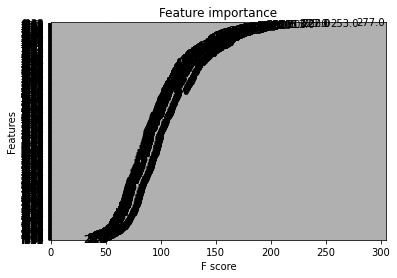

In [ ]:
# Step 6: Feature Importance Visualization
# Plot feature importance
plot_importance(model)
plt.show()


### Test it on the test set

In [ ]:
# Create an empty list to accumulate the data
data_accumulator = []

# Loop through the test_dataset to extract data
for idx in range(len(test_dataset)):
    image, label = test_dataset[idx]
    data_accumulator.append([image, label])

# Create a DataFrame from the accumulated data
test_df = pd.DataFrame(data_accumulator, columns=['image', 'label'])

In [59]:
import torch
from torchvision.models import resnet50

# Replace 'local_path_to_resnet50.pth' with the path to your downloaded model checkpoint
checkpoint_path = '/Users/annabel/iCloud Drive (archive)/Desktop/Stanford/CS229/project/resnet50-19c8e357.pth'

# Load the ResNet-50 model from the local checkpoint file
model = resnet50(pretrained=False)  # Set 'pretrained' to False because you're using a custom checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [60]:
# Initialize lists to store extracted features and labels
extracted_features = []
labels = []

# Loop through the DataFrame
for idx, row in test_df.iterrows():
    image_tensor = row['image']
    label = row['label']
    if idx%1000==0:
        print(idx)

    # Pass the image tensor through the ResNet-50 model to extract features
    with torch.no_grad():
        features = model(image_tensor.unsqueeze(0))

    # Convert the features to a NumPy array
    features_np = features.squeeze().numpy()

    # Append the features and label to the respective lists
    extracted_features.append(features_np)
    labels.append(label)

# Convert the lists to NumPy arrays
features_array_test = np.array(extracted_features)
labels_array_test = np.array(labels)

0
1000
2000
3000
4000
5000


In [61]:
labels_array_test

array([0, 0, 1, ..., 2, 0, 2])

In [62]:
# Save these features into csv file
resnet50_features_test_df = pd.DataFrame(features_array_test, columns=[f'feature_{i}' for i in range(features_array_test.shape[1])])
resnet50_features_test_df['label'] = labels_array_test
resnet50_features_test_df.to_csv('resnet50_feat_test.csv', index=False)

In [68]:
# # To load the model 

import pickle
import xgboost as xgb

# Load the saved model from a file
model_file = 'xgboost_model.pkl'  # Replace with the path to your saved model file

with open(model_file, 'rb') as file:
    loaded_model = pickle.load(file)

# Now, 'loaded_model' contains the XGBoost model loaded from the file


In [70]:
dtest = xgb.DMatrix(features_array_test, label=labels_array_test)

# Make predictions on the test set
y_pred_test = loaded_model.predict(dtest)

# Calculate the confusion matrix
cm = confusion_matrix(y_pred_test, labels_array_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_pred_test, labels_array_test)

print(accuracy)
print(cm)


AttributeError: 'ResNet' object has no attribute 'predict'

Note: oops I rerun the cell and should have, but the test accuracy was 0.78. You could train the model again, but it will take a few minutes.

## Further improvements:
1. Try with log loss metric
2. Run grid search for XGB using the ResNet50 features
3. Try other feature extraction methods